In [1]:
import numpy as np
from matplotlib import pyplot as plt
import py_gauge_mc
import os

from tqdm.notebook import tqdm

## Villain potential

$$ V = \frac{1}{K} \sum_p n_p^2$$

In [2]:
def make_graph(l=8, inv_k=1/2.0,vlen=100,device='gpu'):
    if device == 'gpu':
        graph = py_gauge_mc.GPUGaugeTheory(l,l,l,l,[(n**2)*inv_k for n in range(vlen)])
    elif device == 'cpu':
        graph = py_gauge_mc.GaugeTheory(l,l,l,l,[(n**2)*inv_k for n in range(vlen)])
    return graph

In [3]:
inv_ks = np.linspace(0.01,1.0, 200)
ks = 1/inv_ks

all_ls = [4,6,8,10,12,14,16]
num_experiments = 10


def run_experiment_expand(args):
    return run_experiment(*args)

def run_experiment(l,k,vlen=100):
    g = make_graph(l=l, inv_k=1/k, vlen=vlen)
    for i in range(10):
        g.run_local_update(10)
        g.run_global_update()
    winding_var = g.simulate_and_get_winding_variance(10,5,5)
    return winding_var

filename = 'data.npz'

if os.path.exists(filename):
    arr = np.load(filename)
    all_ls = arr['ls']
    all_windings = arr['data']
else:
    all_windings = []
    for L in tqdm(all_ls, desc='Lattice sizes'):
        windings = []
        for k in tqdm(ks, desc='Potentials',leave=False):
            sub_windings = []
            for i in range(num_experiments):
                winding_vars = run_experiment(L,k,vlen=100)
                sub_windings.append(winding_vars)
            windings.append(sub_windings)
        all_windings.append(windings)
    all_windings = np.array(all_windings)
    np.savez(filename, ls=all_ls, data=all_windings)

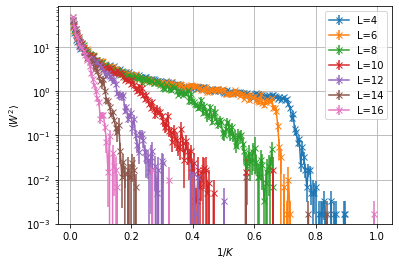

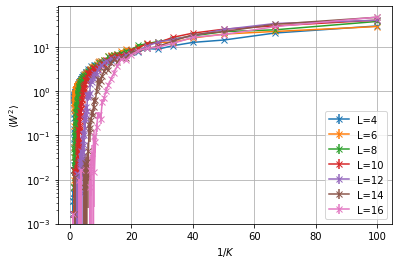

In [4]:
for l, data in zip(all_ls, all_windings):
    plt.errorbar(inv_ks, 
                 data.mean(axis=(-2,-1)), 
                 yerr=np.sqrt(data.mean(axis=-1).var(axis=-1)/num_experiments),
                 marker='x',
                 label=f'L={l}')
plt.grid()
plt.yscale('log')
plt.ylabel(r'$\langle W^2 \rangle$')
plt.xlabel(r'$1/K$')
plt.legend()
plt.savefig('confinement_log.png', dpi=300)
plt.show()

for l, data in zip(all_ls, all_windings):
    plt.errorbar(1./inv_ks, 
                 data.mean(axis=(-2,-1)), 
                 yerr=np.sqrt(data.mean(axis=-1).var(axis=-1)/num_experiments),
                 marker='x',
                 label=f'L={l}')
plt.grid()
plt.yscale('log')
plt.ylabel(r'$\langle W^2 \rangle$')
plt.xlabel(r'$1/K$')
plt.legend()
plt.savefig('confinement_log.png', dpi=300)
plt.show()

Estimate $K_c$ by first zero

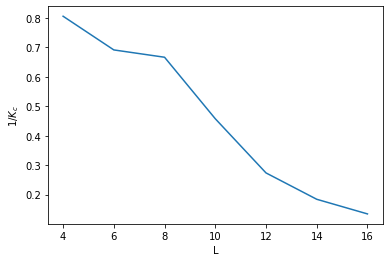

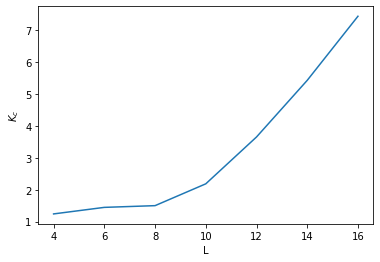

In [5]:
plt.plot(all_ls, inv_ks[np.argmax(all_windings.mean(axis=(-1,-2)) == 0, axis=-1)])
plt.xlabel('L')
plt.ylabel('$1/K_c$')
plt.show()

plt.plot(all_ls, 1./inv_ks[np.argmax(all_windings.mean(axis=(-1,-2)) == 0, axis=-1)])
plt.xlabel('L')
plt.ylabel('$K_c$')
plt.show()

Local variances

In [6]:
inv_ks = np.linspace(0.01,1.0, 20)
ks = 1/inv_ks

all_ls = [4,6,8,10,12,14,16]
num_experiments = 10

def run_experiment(l,k,vlen=100):
    g = make_graph(l=l, inv_k=1/k, vlen=vlen)
    all_data = []
    for i in range(10):
        for i in range(10):
            g.run_local_update(10)
            g.run_global_update()
        all_data.append(g.get_graph_state())
    return np.array(all_data)

data_dir = 'raw_data'

for L in tqdm(all_ls, desc='Lattice sizes'):
    filename = os.path.join(data_dir, '{}.npz'.format(L))
    if os.path.exists(filename):
        pass
    else:
        l_data = []
        for k in tqdm(ks, desc='Potentials',leave=False):
            l_k_data = []
            for i in range(num_experiments):
                l_k_data.append(run_experiment(L,k,vlen=100))
            l_data.append(l_k_data)
        l_data = np.array(l_data)
        np.savez(filename, ls=all_ls, data=l_data)

Lattice sizes:   0%|          | 0/7 [00:00<?, ?it/s]

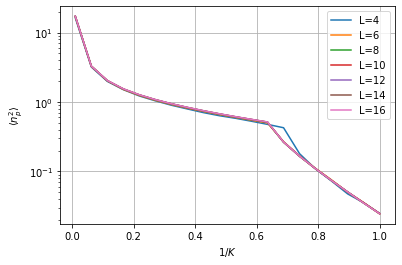

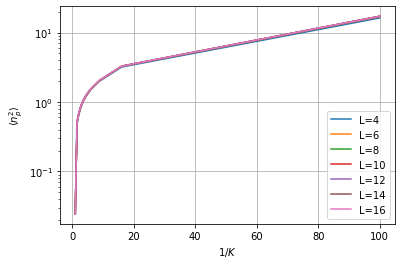

In [7]:
var_axis = tuple([-x for x in range(1,8)])
for L in all_ls:
    filename = os.path.join(data_dir, '{}.npz'.format(L))
    arr = np.load(filename)
    l_data = arr['data']
    l_data_var = l_data.var(axis=var_axis)
    plt.plot(inv_ks, l_data_var, label="L={}".format(L))
plt.yscale('log')
plt.xlabel(r'$1/K$')
plt.ylabel(r'$\langle n_p^2 \rangle$')
plt.grid()
plt.legend()
plt.show()

var_axis = tuple([-x for x in range(1,8)])
for L in all_ls:
    filename = os.path.join(data_dir, '{}.npz'.format(L))
    arr = np.load(filename)
    l_data = arr['data']
    l_data_var = l_data.var(axis=var_axis)
    plt.plot(1./inv_ks, l_data_var, label="L={}".format(L))
plt.yscale('log')
plt.xlabel(r'$1/K$')
plt.ylabel(r'$\langle n_p^2 \rangle$')
plt.grid()
plt.legend()
plt.show()

In [ ]:
hist_data = []
for L in all_ls:
    filename = os.path.join(data_dir, '{}.npz'.format(L))
    arr = np.load(filename)
    l_data = arr['data']
    sub_hist_data = []
    for i in range(l_data.shape[0]):
        sub_hist_data.append(np.unique(l_data[i], return_counts=True))
    hist_data.append(sub_hist_data)

In [ ]:
for L, l_data in zip(all_ls, hist_data):
    for inv_k, (k_values, k_counts) in zip(inv_ks, l_data):
        plt.plot(k_values, k_counts, label="$K^-1 = {:.2f}$".format(inv_k))
    xlow, xhigh = plt.xlim()
    plt.xlim([-max(abs(xlow),xhigh), max(abs(xlow),xhigh)])
    plt.title('L={}'.format(L))
    plt.show()